In [20]:
import mne
import numpy as np
import scipy.io
from mne.io import RawArray, Raw
from mne.channels import make_standard_montage
from mne import create_info
import matplotlib.pyplot as plt

In [21]:
path = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\wang_experiment\sunsun.mat"
raw_mat = scipy.io.loadmat(path)

In [22]:
epoch_data = raw_mat["data"]
epoch_data.shape

(9, 1500, 5, 9)

In [23]:
stim = np.zeros((1, *epoch_data.shape[1:]))
stim.shape

(1, 1500, 5, 9)

In [24]:
data = np.transpose(epoch_data, (0, 3, 2, 1))
data.shape

(9, 9, 5, 1500)

In [25]:
montage = make_standard_montage("standard_1020")
montage.rename_channels(
    {ch_name: ch_name.upper() for ch_name in montage.ch_names}
)
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>

In [26]:
_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
ch_names = [ch_name.upper() for ch_name in _CHANNELS]
ch_names = ch_names + ['STIM']
ch_types = ["eeg"] * 9
ch_types[-1] = "stim"

In [27]:
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=250)
info

<Info | 7 non-empty values
 bads: []
 ch_names: FZ, C3, CZ, C4, PZ, PO7, OZ, PO8, STIM
 chs: 8 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
>

In [28]:
raw = RawArray(
        data=np.reshape(data, (data.shape[0], -1)), 
        info=info
    )
raw.set_montage(montage)
raw.filter(5, 90, l_trans_bandwidth=2,h_trans_bandwidth=5,
        phase='zero-double')

Creating RawArray with float64 data, n_channels=9, n_times=67500
    Range : 0 ... 67499 =      0.000 ...   269.996 secs
Ready.


<RawArray | 9 x 67500 (270.0 s), ~4.7 MB, data loaded>

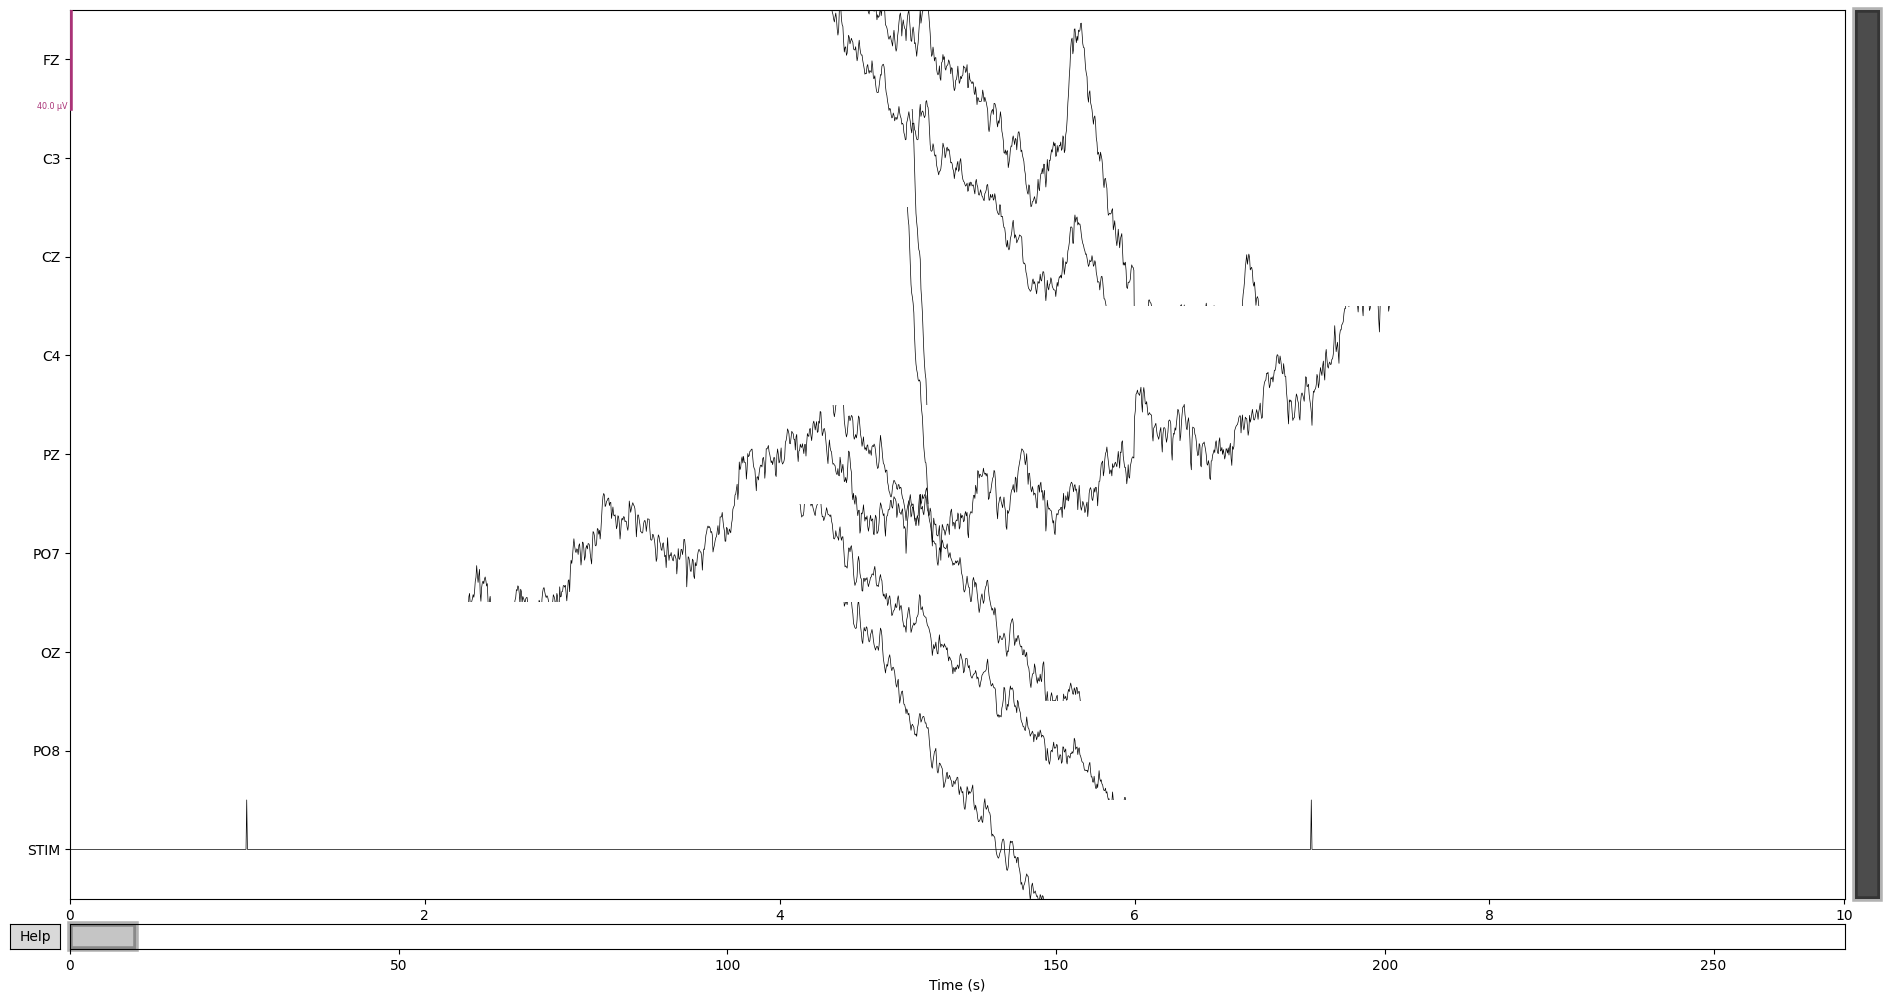

Effective window size : 1.024 (s)


c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


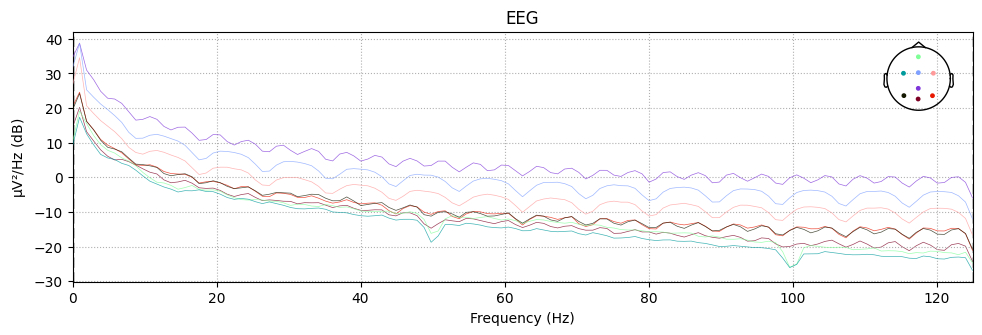

In [29]:
raw.plot()
plt.show()
raw.compute_psd().plot()
plt.show()

In [30]:
events = mne.find_events(raw)
channels = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
picks = mne.pick_channels(raw.ch_names, channels, ordered=True)
epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=0.14, tmax=0.636, reject=None, reject_by_annotation=False, picks=picks)

45 events found
Event IDs: [1 2 3 4 5 6 7 8 9]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


In [31]:
epochs.get_data().shape

Using data from preloaded Raw for 45 events and 125 original time points ...
0 bad epochs dropped


(45, 8, 125)

In [32]:
from numpy import ndarray
import numpy as np
from scipy.sparse import vstack, identity, spmatrix
from typing import Optional, cast, Union
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from joblib import Parallel, delayed
from functools import partial



def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U


def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X 
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos


class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels, feat


def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [33]:
X = epochs.get_data()[:,:-1,:-1]
dropped_epochs = [n for n, dl in enumerate(epochs.drop_log) if len(dl)]  # result is a list
print(dropped_epochs)

Using data from preloaded Raw for 45 events and 125 original time points ...
[]


In [34]:
print(dropped_epochs)

[]


In [35]:
import numpy as np

events = np.delete(events, dropped_epochs, axis=0)
events[:,-1].shape

(45,)

In [36]:
y = events[:,-1]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [40]:
from sklearn.utils import shuffle

FREQS = [8, 8.2, 8.4, 8.6, 8.8, 9, 9.2, 9.4, 9.6]
PHASES = [0 , 0.35 , 0.70 , 1.05 , 1.40 , 1.75, 0.10, 0.45, 0.80 ]
# FREQS = [8,9,10,11,12,13,14,15,8.2,9.2,10.2,11.2,12.2,13.2,14.2,15.2,8.4,9.4,10.4,11.4,12.4,13.4,14.4,15.4,8.6,9.6,10.6,11.6,12.6,13.6,14.6,15.6,8.8,9.8,10.8,11.8,12.8,13.8,14.8,15.8]
# PHASES = [0,0.5,1,1.5,0,0.5,1,1.5,0.5,1,1.5,0,0.5,1,1.5,0,1,1.5,0,0.5,1,1.5,0,0.5,1.5,0,0.5,1,1.5,0,0.5,1,0,0.5,1,1.5,0,0.5,1,1.5]

Yf = generate_cca_references(freqs=FREQS, srate=250, T=3.7, phases=PHASES, n_harmonics=5)
# Yf = generate_cca_references(freqs=FREQS, srate=250, T=3, phases=PHASES, n_harmonics=5)

estimator=TRCA(n_components = 1, n_jobs=-1)

model = estimator.fit(X_train, y_train, Yf)
X_test, y_test = shuffle(X_test, y_test)
preds, _ = model.predict(X_test)
acc = np.mean(preds==y_test)
print(preds)
print(y_test)
print(acc)

[9 7 2 2 9 3 3 4 4 2 5 5 3 2]
[3 1 2 2 8 4 6 8 1 7 7 7 1 2]
0.21428571428571427
